# CS 5824: Semester Project
Application of dynamic action space method from Woo & Sung (2020) to Walker2D (MuJoCo)

## Imports

In [ ]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb x11-utils

!apt-get install -y \
   libgl1-mesa-dev \
   libgl1-mesa-glx \
   libglew-dev \
   libosmesa6-dev \
   software-properties-common

!apt-get install -y patchelf 

!pip install free-mujoco-py

In [ ]:
!pip install h5py
!pip install typing-extensions
!pip install wheel

In [ ]:
!pip install gym #==0.19.0
!pip install -U gym[mujoco]

See: https://mgoulao.github.io/gym-docs/environments/mujoco/walker2d/

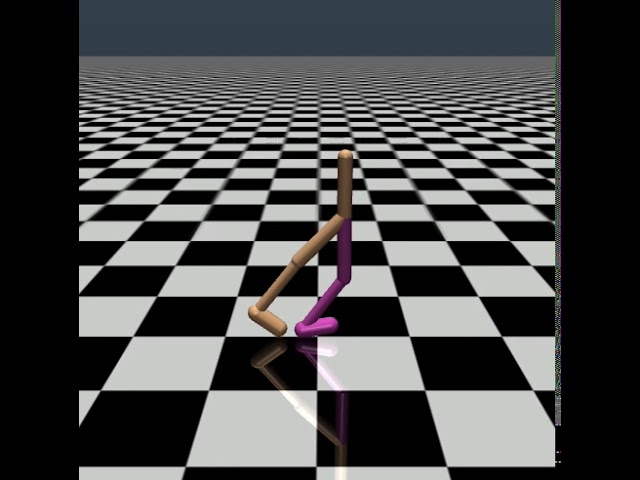

In [ ]:
import gym
import numpy as np
env = gym.make('Walker2d-v2', render_mode='rgb_array')
np.random.seed(42)

In [ ]:
env.action_space

## Config for in-notebook display

In [ ]:
!pip install pyvirtualdisplay
!pip install piglet

In [ ]:
# Virtual display of environment
from pyvirtualdisplay import Display
MAX_STEPS = 400
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"

video = VideoRecorder(env, before_training)
# returns an initial observation
env.reset()

video.capture_frame()

for i in range(MAX_STEPS):
  video.capture_frame()
  # truncated is for possible OOBs, terminated is for complete MDP
  observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
  ##Not printing this time
  #print("step", i, observation, reward, done, info)

video.close()

In [ ]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

## Proximal Policy Optimization (Easy)

In [ ]:
#!pip install stable_baselines3
!pip install git+https://github.com/carlosluis/stable-baselines3@fix_tests

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

In [ ]:
env = make_vec_env("Walker2d-v2", n_envs=1)

model = PPO("MlpPolicy", env)
model.learn(total_timesteps=1000000)
model.save("walker2d")

In [ ]:
model = PPO.load("walker2d")
after_training = "after_training.mp4"

video = VideoRecorder(env, after_training)
obs = env.reset()
cumulative_rewards = []
total_reward = 0

end_i = -1

for i in range(MAX_STEPS * 5):
  video.capture_frame()
  action, _states = model.predict(obs)
  obs, rewards, done, info = env.step(action)

  total_reward += rewards[0]
  cumulative_rewards.append(total_reward)

  if done:
    end_i = i
    break

  env.render()

if end_i == -1: 
  end_i = MAX_STEPS * 5
video.close()

html = render_mp4(after_training)
HTML(html)

In [ ]:
import matplotlib.pyplot as plt

x = range(end_i + 1)
plt.plot(x, cumulative_rewards)
plt.title('Cumulative Training Reward vs Steps')
plt.xlabel('# of steps')
plt.ylabel('Reward')
plt.show()

# Proximal Policy Optimization (Hard)
From scratch. 
https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/

Disclaimer: *heavily* used https://github.com/nikhilbarhate99/PPO-PyTorch/.

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

In [ ]:
device = torch.device('cpu')
if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 

In [ ]:
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std_init):
        super(ActorCritic, self).__init__()

        self.action_dim = action_dim
        self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        self.actor = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, action_dim),
                        nn.Tanh()
                    )
        
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
        
    def set_action_std(self, new_action_std):
        self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)

    def forward(self):
        raise NotImplementedError

    def act(self, state):
        action_mean = self.actor(state)
        cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
        dist = MultivariateNormal(action_mean, cov_mat)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()
    

    def evaluate(self, state, action):
        action_mean = self.actor(state)
        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var).to(device)
        dist = MultivariateNormal(action_mean, cov_mat)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy        

In [ ]:
class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, action_std_init=0.6):
        self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()

    def set_action_std(self, new_action_std):
        self.action_std = new_action_std
        self.policy.set_action_std(new_action_std)
        self.policy_old.set_action_std(new_action_std)

    def decay_action_std(self, action_std_decay_rate, min_action_std):
        self.action_std = self.action_std - action_std_decay_rate
        self.action_std = round(self.action_std, 4)
        if (self.action_std <= min_action_std):
            self.action_std = min_action_std
            print("setting actor output action_std to min_action_std : ", self.action_std)
        else:
            print("setting actor output action_std to : ", self.action_std)
        self.set_action_std(self.action_std)

    def select_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            action, action_logprob, state_val = self.policy_old.act(state)

        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)
        self.buffer.state_values.append(state_val)

        return action.detach().cpu().numpy().flatten()

    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

In [ ]:
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format("Walker2d-v2", 42, 0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
lr_actor = 0.0003  # learning rate for actor network
lr_critic = 0.001  # learning rate for critic network
gamma = 0.99  # discount factor
K_epochs = 40  # update policy for K epochs
eps_clip = 0.2  # clip parameter for PPO
has_continuous_action_space = False
action_std = None

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

In [ ]:
# Training
cumulative_rewards = []
total_reward = 0

for i in range(1000000):
  obs = env.reset()

  for j in range(MAX_STEPS):
    action = ppo_agent.select_action(obs)
    obs, reward, done, info = env.step(action)

    ppo_agent.buffer.rewards.append(reward)
    ppo_agent.buffer.is_terminals.append(done)

    total_reward += reward

    if i % (MAX_STEPS * 4) == 0:
        ppo_agent.update()
      
    if i % action_std_decay_freq == 0:
      ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

    if time_step % save_model_freq == 0:
      ppo_agent.save(checkpoint_path)
    
    if done:
      break

In [ ]:
# Testing
ppo_agent.load(checkpoint_path)
from_scratch = "from_scratch.mp4"
video = VideoRecorder(env, from_scratch)

obs = env.reset()
total_reward_arr = []
total_reward = 0
end_i = -1

for i in range(MAX_STEPS * 5):
  video.capture_frame()
  action = ppo_agent.select_action(obs)
  obs, reward, done, info = env.step(action)
  total_reward += reward
  total_reward_arr.append(total_reward)

  if done:
    end_i = i
    break
  
  env.render()

env.close()

if end_i == -1: 
  end_i = MAX_STEPS * 5
video.close()

html = render_mp4(from_scratch)
HTML(html)

In [ ]:
x = range(end_i + 1)
plt.plot(x, total_reward_arr)
plt.title('Cumulative Training Reward vs Steps')
plt.xlabel('# of steps')
plt.ylabel('Reward')
plt.show()